# 1.Load data

In [ ]:
from google.colab import files
var=files.upload()

Saving ner_dataset.csv to ner_dataset.csv


In [ ]:
import pandas as pd

In [ ]:
data = pd.read_csv('ner_dataset.csv', encoding= 'unicode_escape')
data.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O


In [ ]:
data.shape

(1048575, 4)

We can see that the sentences are broken into tokens in the column 'Word'. The column 'sentence #' displays the sentence number once and then prints NaN till the next sentence begins.

## 2. Extract mappings required for the neural network
To train a neural network, we will use two mappings as given below. The neural network will only take integers as input. So lets convert all the unique tokens in the corpus to its respective index.
- {token} to {token id}: address the row in embeddings matrix for the current token.
- {tag} to {tag id}: one-hot ground truth probability distribution vectors for computing the loss at the output of the network.

In [ ]:
from itertools import chain
def get_dict_map(data, token_or_tag):
    tok2idx = {}
    idx2tok = {}
    
    if token_or_tag == 'token':
        vocab = list(set(data['Word'].to_list()))
    else:
        vocab = list(set(data['Tag'].to_list()))
    
    idx2tok = {idx:tok for  idx, tok in enumerate(vocab)}
    tok2idx = {tok:idx for  idx, tok in enumerate(vocab)}
    return tok2idx, idx2tok


token2idx, idx2token = get_dict_map(data, 'token')
tag2idx, idx2tag = get_dict_map(data, 'tag')

In [ ]:
data['Word_idx'] = data['Word'].map(token2idx)
data['Tag_idx'] = data['Tag'].map(tag2idx)

In [ ]:
data.head()

,Sentence #,Word,POS,Tag,Word_idx,Tag_idx
0,Sentence: 1,Thousands,NNS,O,6662,12
1,NaN,of,IN,O,15526,12
2,NaN,demonstrators,NNS,O,7670,12
3,NaN,have,VBP,O,33525,12
4,NaN,marched,VBN,O,16507,12


In [ ]:
tag2idx

{'B-art': 7,
 'B-eve': 8,
 'B-geo': 11,
 'B-gpe': 0,
 'B-nat': 15,
 'B-org': 3,
 'B-per': 13,
 'B-tim': 4,
 'I-art': 14,
 'I-eve': 9,
 'I-geo': 2,
 'I-gpe': 5,
 'I-nat': 10,
 'I-org': 1,
 'I-per': 16,
 'I-tim': 6,
 'O': 12}

## 3. Transform columns to extract sequential data
Next, lets fill NaN in 'sentence #' column using method ffill in fillna. Thereafter groupby on the sentence column to get a list of tokens and tags for each sentence.

In [ ]:
data.isna().any()

Sentence #     True
Word          False
POS           False
Tag           False
Word_idx      False
Tag_idx       False
dtype: bool

In [ ]:
data_fillnan=data.ffill(axis=0)
data_fillnan.head(50)

,Sentence #,Word,POS,Tag,Word_idx,Tag_idx
0,Sentence: 1,Thousands,NNS,O,6662,12
1,Sentence: 1,of,IN,O,15526,12
2,Sentence: 1,demonstrators,NNS,O,7670,12
3,Sentence: 1,have,VBP,O,33525,12
4,Sentence: 1,marched,VBN,O,16507,12
5,Sentence: 1,through,IN,O,31346,12
6,Sentence: 1,London,NNP,B-geo,28452,11
7,Sentence: 1,to,TO,O,34714,12
8,Sentence: 1,protest,VB,O,17378,12
9,Sentence: 1,the,DT,O,23711,12


In [ ]:
data_fillna = data.fillna(method='ffill', axis=0)
data_group = data_fillna.groupby(['Sentence #'],as_index=False
                                )['Word', 'POS', 'Tag', 'Word_idx', 'Tag_idx'].agg(lambda x: list(x))

data_group.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  This is separate from the ipykernel package so we can avoid doing imports until


,Sentence #,Word,POS,Tag,Word_idx,Tag_idx
0,Sentence: 1,"[Thousands, of, demonstrators, have, marched, ...","[NNS, IN, NNS, VBP, VBN, IN, NNP, TO, VB, DT, ...","[O, O, O, O, O, O, B-geo, O, O, O, O, O, B-geo...","[6662, 15526, 7670, 33525, 16507, 31346, 28452...","[12, 12, 12, 12, 12, 12, 11, 12, 12, 12, 12, 1..."
1,Sentence: 10,"[Iranian, officials, say, they, expect, to, ge...","[JJ, NNS, VBP, PRP, VBP, TO, VB, NN, TO, JJ, J...","[B-gpe, O, O, O, O, O, O, O, O, O, O, O, O, O,...","[8922, 17750, 17342, 12424, 10689, 34714, 1627...","[0, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12..."
2,Sentence: 100,"[Helicopter, gunships, Saturday, pounded, mili...","[NN, NNS, NNP, VBD, JJ, NNS, IN, DT, NNP, JJ, ...","[O, O, B-tim, O, O, O, O, O, B-geo, O, O, O, O...","[1566, 25702, 2196, 30333, 16123, 25662, 10494...","[12, 12, 4, 12, 12, 12, 12, 12, 11, 12, 12, 12..."
3,Sentence: 1000,"[They, left, after, a, tense, hour-long, stand...","[PRP, VBD, IN, DT, NN, JJ, NN, IN, NN, NNS, .]","[O, O, O, O, O, O, O, O, O, O, O]","[3756, 516, 13538, 3368, 19114, 18224, 2309, 2...","[12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12]"
4,Sentence: 10000,"[U.N., relief, coordinator, Jan, Egeland, said...","[NNP, NN, NN, NNP, NNP, VBD, NNP, ,, NNP, ,, J...","[B-geo, O, O, B-per, I-per, O, B-tim, O, B-geo...","[32667, 5643, 25380, 15348, 22647, 16710, 2613...","[11, 12, 12, 13, 16, 12, 4, 12, 11, 12, 0, 12,..."


## 4. Pad sequences and split the dataset into train, test


In [ ]:
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

In [ ]:
#check words and tag from final_data
print("statements: \n",data_group['Word'])
print("\n")
print("Tags: \n",data_group['Tag'])

#Getting max size of tokens and padding tokens
n_token = len(list(set(data['Word'].to_list())))
tokens = data_group['Word_idx'].tolist()
maxlen = max([len(s) for s in tokens])
print("\nMaximum size of statements is :",maxlen)
pad_tokens = pad_sequences(tokens, maxlen=maxlen, dtype='int32', padding='post', value= n_token - 1)

#getting max size of tag and padding tags   
n_tag = len(list(set(data['Tag'].to_list())))
tags = data_group['Tag_idx'].tolist()
print("\nMaximum size of statements is :",tags)
pad_tags = pad_sequences(tags, maxlen=maxlen, dtype='int32', padding='post', value= tag2idx["O"])

print("Statements after padding:\n",pad_tokens)
print("Tags after padding:\n",pad_tags)
    
n_tags = len(tag2idx)
pad_tags = [to_categorical(i, num_classes=n_tags) for i in pad_tags]



statements: 
 0        [Thousands, of, demonstrators, have, marched, ...
1        [Iranian, officials, say, they, expect, to, ge...
2        [Helicopter, gunships, Saturday, pounded, mili...
3        [They, left, after, a, tense, hour-long, stand...
4        [U.N., relief, coordinator, Jan, Egeland, said...
                               ...                        
47954    [Opposition, leader, Mir, Hossein, Mousavi, ha...
47955    [On, Thursday, ,, Iranian, state, media, publi...
47956    [Following, Iran, 's, disputed, June, 12, elec...
47957    [Since, then, ,, authorities, have, held, publ...
47958    [The, United, Nations, is, praising, the, use,...
Name: Word, Length: 47959, dtype: object


Tags: 
 0        [O, O, O, O, O, O, B-geo, O, O, O, O, O, B-geo...
1        [B-gpe, O, O, O, O, O, O, O, O, O, O, O, O, O,...
2        [O, O, B-tim, O, O, O, O, O, B-geo, O, O, O, O...
3                        [O, O, O, O, O, O, O, O, O, O, O]
4        [B-geo, O, O, B-per, I-per, O, B-tim, O, 

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Statements after padding:
 [[ 6662 15526  7670 ... 35177 35177 35177]
 [ 8922 17750 17342 ... 35177 35177 35177]
 [ 1566 25702  2196 ... 35177 35177 35177]
 ...
 [28080 31176 32058 ... 35177 35177 35177]
 [21452 12508 24017 ... 35177 35177 35177]
 [21918 10431  2924 ... 35177 35177 35177]]
Tags after padding:
 [[12 12 12 ... 12 12 12]
 [ 0 12 12 ... 12 12 12]
 [12 12  4 ... 12 12 12]
 ...
 [12 11 12 ... 12 12 12]
 [12 12 12 ... 12 12 12]
 [12  3  1 ... 12 12 12]]


In [ ]:
 #splitting the data in training and test sets
train_tokens, test_tokens, train_tags, test_tags = train_test_split(pad_tokens, pad_tags, test_size=0.1, train_size=0.9, random_state=2020)

print(
        'train_tokens length:', len(train_tokens),
        '\ntest_tokens length:', len(test_tokens),
        '\ntrain_tags:', len(train_tags),
        '\ntest_tags:', len(test_tags)
    )

train_tokens length: 43163 
test_tokens length: 4796 
train_tags: 43163 
test_tags: 4796


In [ ]:
for token, tag in zip(train_tokens[0], train_tags[0]):
    print('%s\t%s' % (token, tag))

17249	[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
17342	[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
23924	[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
34712	[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
33587	[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
20614	[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
34714	[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
4363	[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
17196	[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
18865	[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
24017	[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
31111	[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
12424	[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
8217	[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
19556	[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
28164	[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
228	[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
2

## 5. Build Model Layout
 
Lets go through the process of building a neural network model with lstm layers.. We have built a simple model with 4 layers.
 
-

In [ ]:
import numpy as np
import tensorflow
from tensorflow.keras import Sequential, Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from tensorflow.keras.utils import plot_model

# import keras as k

In [ ]:
from numpy.random import seed
seed(1)
tensorflow.random.set_seed(2)

In [ ]:
input_dim = len(list(set(data['Word'].to_list())))+1
output_dim = 32
input_length = max([len(s) for s in data_group['Word_idx'].tolist()])
n_tags = len(tag2idx)
print('input_dim: ', input_dim, '\noutput_dim: ', output_dim, '\ninput_length: ', input_length, '\nn_tags: ', n_tags)

input_dim:  35179 
output_dim:  32 
input_length:  104 
n_tags:  17


In [ ]:
def get_bilstm_lstm_model():
    model = Sequential()

    # Add Embedding layer
    model.add(Embedding(input_dim=input_dim, output_dim=output_dim, input_length=input_length))

    # Add bidirectional LSTM
    model.add(Bidirectional(LSTM(units=output_dim, return_sequences=True, dropout=0.2, recurrent_dropout=0.2), merge_mode = 'concat'))

    # Add LSTM
    model.add(LSTM(units=output_dim, return_sequences=True, dropout=0.5, recurrent_dropout=0.5))

    # Add timeDistributed Layer
    model.add(TimeDistributed(Dense(n_tags, activation="relu")))

    #Optimiser 
    # adam = k.optimizers.Adam(lr=0.0005, beta_1=0.9, beta_2=0.999)

    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    
    return model

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 104, 32)           1125728   
_________________________________________________________________
bidirectional (Bidirectional (None, 104, 64)           16640     
_________________________________________________________________
lstm_1 (LSTM)                (None, 104, 32)           12416     
_________________________________________________________________
time_distributed (TimeDistri (None, 104, 17)           561       
Total params: 1,155,345
Trainable params: 1,155,345
Non-trainable params: 0
_________________________________________________________________


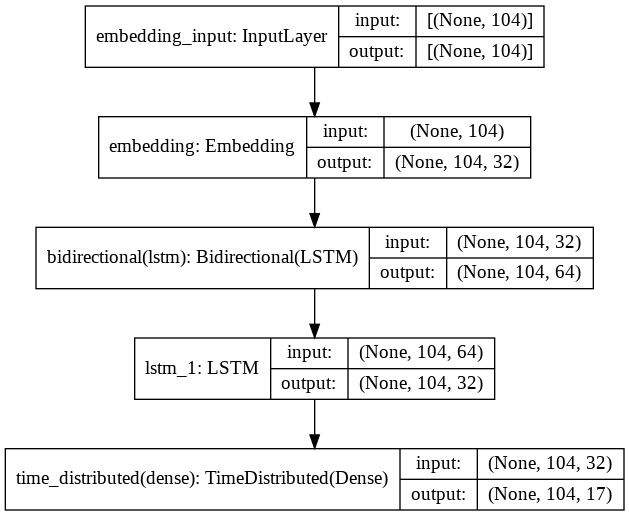

In [ ]:
def train_model(X, y, model):
    loss = list()
    for _ in range(25):
        # fit model for one epoch on this sequence
        hist = model.fit(X, y, batch_size=1000, verbose=1, epochs=1, validation_split=0.2)
        loss.append(hist.history['loss'][0])
    return loss
model_bilstm_lstm = get_bilstm_lstm_model()
plot_model(model_bilstm_lstm,show_shapes=True)

In [ ]:
results = pd.DataFrame()
results['with_add_lstm'] = train_model(train_tokens, np.array(train_tags), model_bilstm_lstm)

35/35 [==============================] - 75s 2s/step - loss: 0.1062 - accuracy: 0.9692 - val_loss: 0.1160 - val_accuracy: 0.9690


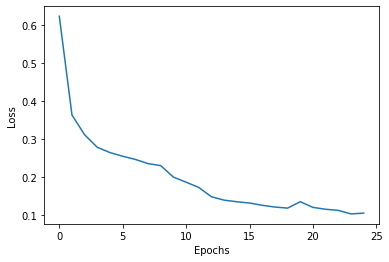

In [ ]:
import matplotlib.pyplot as plt
plt.plot(results['with_add_lstm'])
plt.xlabel('Epochs');
plt.ylabel('Loss');

Model started with 0.9269 accuracy ended. After running 25 epochs with 1000 batch size, the final accuracy was 0.9687.

## spaCy entities

In [ ]:
import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_sm')

In [ ]:
text = nlp(
    'Jim bought 300 shares of Acme Corp. in 2006. And producing an annotated block of text that \
    highlights the names of entities: [Jim]Person bought 300 shares of \
    [Acme Corp.]Organization in [2006]Time. In this example, a person name consisting \
    of one token, a two-token company name and a temporal expression have been detected \
    and classified.State-of-the-art NER systems for English produce near-human performance. \
    For example, the best system entering MUC-7 scored 93.39% of F-measure while human \
    annotators scored 97.60% and 96.95%.[1][2]')

In [ ]:
text=nlp('Mark Zuckerberg is one of the founders of Facebook, a company from the United States established in 2006 with 98% profit ')

In [ ]:
for w in text.ents:
    print(w.text, w.label_)

Mark Zuckerberg PERSON
one CARDINAL
Facebook ORG
the United States GPE
2006 DATE
98% PERCENT


In [ ]:
displacy.render(text, style = 'ent', jupyter=True)

In [ ]:
spacy.explain('CARDINAL')

'Numerals that do not fall under another type'